In [61]:
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
from hipposlam.utils import read_pickle
from hipposlam.comput_utils import Arena, circular_gau_filter
from hipposlam.Sequences import Sequences, createX
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter

import numpy as np
import collections
import os
from tqdm import tqdm

In [67]:
debug_plot_tag = True
project_name = 'StateMapLearnerTaughtForest_R5L20_dp2_da8'
project_dir = join('data', project_name)
plot_dir = join('plots', project_name)
os.makedirs(plot_dir, exist_ok=True)
chpt_name = 'PPO$_FullySupervised'
max_chpt_num = 1

# Append traj data and fsigma
trajkeys = 't', 'x', 'y', 'a', 'sid', 'r', 'terminated', 'truncated'
alltrajdict = {key:[] for key in trajkeys}
allfsigmalist = []
for i in range(1, max_chpt_num+1):
    traj_data_pth = join(project_dir, chpt_name.replace('$', '%d'%i) + '_trajdata.pickle')
    trajdict_list = read_pickle(traj_data_pth)  # a list of dictionaries, each for one episode
    for trajdict in trajdict_list:
        # Traj data
        for key in trajkeys:
            alltrajdict[key].extend(trajdict[key])
        # Fsigma
        allfsigmalist.extend(trajdict['fsigma'])
alltrajdf = pd.DataFrame(alltrajdict)

# Load hipposlam
load_hipposlam_pth = join(project_dir, chpt_name.replace('$', '%d'%max_chpt_num) + '_hipposlam.pickle')
hipposlam = read_pickle(load_hipposlam_pth)
hipposeq = hipposlam['hipposeq']
hippomap = hipposlam['hippomap']
hippoteach = hipposlam['hippoteach']
fpos = hipposlam['fpos']
R = hipposeq.R
L = hipposeq.L
F = hipposeq.num_f
K = hipposeq.X_Ncol
stored_f = hipposeq.stored_f
id2fkey_dict = {val:key for key, val in stored_f.items()}

# Assert data validity
assert R == hippomap.R
assert F == hippomap.current_F
assert K == hippomap.K
assert alltrajdf.shape[0] == len(allfsigmalist)

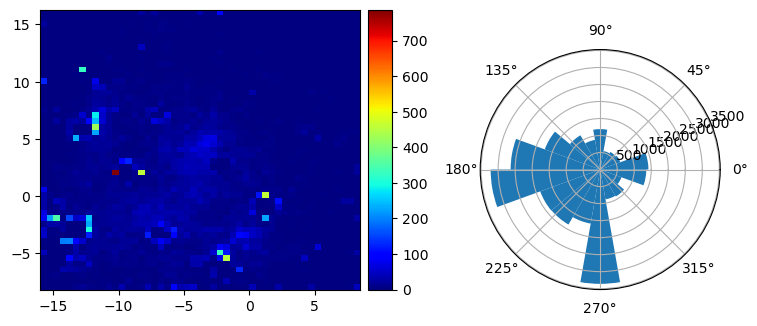

In [59]:
# Occpancy ===========================
bodysd = 0.15  # body length of the robot = 0.3m
dp = 0.5
da = 2*np.pi/18
xmin = np.floor(alltrajdf['x'].min() * 10) / 10
xmax = np.ceil(alltrajdf['x'].max() * 10) / 10
ymin = np.floor(alltrajdf['y'].min() * 10) / 10
ymax = np.ceil(alltrajdf['y'].max() * 10) / 10
amin, amax = -np.pi, np.pi

BD = Arena(xmin, xmax, ymin, ymax, amin, amax, dp, da, bodysd)
occ, edges3d = BD.compute_histogram3d(alltrajdf['x'].to_numpy(), alltrajdf['y'].to_numpy(), alltrajdf['a'].to_numpy())
occ_p = occ.sum(axis=2)
occ_a = occ.sum(axis=0).sum(axis=0)
if debug_plot_tag:
    fig = plt.figure(figsize=(8, 4), facecolor='w')
    ax1 = fig.add_axes([0.05, 0.2, 0.4, 0.7])
    ax2 = fig.add_axes([0.55, 0.2, 0.4, 0.6], polar=True)
    cbar_ax = fig.add_axes([0.46, 0.2, 0.03, 0.7])
    im1 = ax1.pcolormesh(BD.xedges, BD.yedges, occ_p.T, cmap='jet')
    cb = fig.colorbar(im1, cax=cbar_ax)
    ax2.bar(BD.aedm, occ_a, width=da)
    fig.savefig(join(plot_dir, 'Occupancy.png'))

In [93]:

# Obtain x, y, a data for each sigma
xdict = collections.defaultdict(list)
ydict = collections.defaultdict(list)
adict = collections.defaultdict(list)
for t in range(alltrajdf.shape[0]):
    x = alltrajdf['x'][t]
    y = alltrajdf['y'][t]
    a = alltrajdf['a'][t]
    fsigma = allfsigmalist[t]

    X = createX(R, F, K, stored_f, fsigma)
    fnode_ids, sigma_ids = Sequences.X2sigma(X, R, sigma_state=False)

    for fnode_id, sigma_id in zip(fnode_ids, sigma_ids):
        nodekey = id2fkey_dict[fnode_id]
        ensem_key = '%s-%d'%(nodekey, sigma_id)
        xdict[ensem_key].append(x)
        ydict[ensem_key].append(y)
        adict[ensem_key].append(a)



In [95]:
plot_dir_ratemap = join(plot_dir, 'ratemaps')
os.makedirs(plot_dir_ratemap, exist_ok=True)
print('Compute ratemaps')
print('Save at ', plot_dir_ratemap)

all_ratemaps = np.zeros((len(xdict), BD.xedm.shape[0], BD.yedm.shape[0], BD.aedm.shape[0]))
for i, ensem_key in enumerate(tqdm(xdict)):
    if i > 50:
        break

    xsp = xdict[ensem_key]
    ysp = ydict[ensem_key]
    asp = adict[ensem_key]
    fposeach = fpos[ensem_key.split('_')[0]]

    Hsp3d, _ = BD.compute_histogram3d(xsp, ysp, asp)
    ratemap_3d = BD.compute_ratemap(occ, Hsp3d)
    maptmp = gaussian_filter(ratemap_3d, sigma=BD.bodysd_ind, mode='constant', cval=0, axes=(0, 1))
    ratemap_3d_gau = circular_gau_filter(maptmp, a_ax=BD.aedm, kappa=4*np.pi)
    all_ratemaps[i, :, :, :] = ratemap_3d_gau

    if debug_plot_tag:
        ratemap_pos = ratemap_3d_gau.mean(axis=2)
        ratemap_a = ratemap_3d_gau.mean(axis=0).mean(axis=0)

        fig = plt.figure(figsize=(8, 4), facecolor='w')
        ax1 = fig.add_axes([0.05, 0.2, 0.4, 0.7])
        ax2 = fig.add_axes([0.55, 0.2, 0.4, 0.6], polar=True)
        cbar_ax = fig.add_axes([0.46, 0.2, 0.03, 0.7])


        im1 = ax1.pcolormesh(BD.xedges, BD.yedges, ratemap_pos.T, cmap='jet')
        ax1.scatter(fposeach[0], fposeach[1], color='g', s=100)
        r = 2
        # ax1.quiver(xsp, ysp, r* np.cos(asp), r*np.sin(asp), color='r', alpha=0.5, scale=75)
        ax1.set_xlim(xmin, xmax)
        ax1.set_ylim(ymin, ymax)
        ax1.set_title(ensem_key)
        cb = fig.colorbar(im1, cax=cbar_ax)

        ax2.bar(BD.aedm, ratemap_3d.mean(axis=0).mean(axis=0), width=da, alpha=0.5)
        ax2.plot(BD.aedm, ratemap_a, c='k')
        # ax2.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
        # ax2.set_xticks(np.arange(-np.pi, np.pi + np.pi/4, np.pi/4), minor=True)
        # ax2.set_xticklabels(['-180', '-90', '0', '90', '180'])

        fig.savefig(join(plot_dir_ratemap, '%d.png'%(i)), dpi=200)
        plt.close(fig)
        # raise ValueError

Compute ratemaps
Save at  plots\StateMapLearnerTaughtForest_R5L20_dp2_da8\ratemaps


  3%|▎         | 51/1647 [00:18<09:37,  2.76it/s]
